<a href="https://colab.research.google.com/github/Dyaruro1/CO2-Wounds-Segmentation/blob/main/Proyecto_IA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga del dataset y Exploracion de datos

## Carga del Dataset

Aca tienen que generar un token del dataset para que puedan tener acceso *(Sera el token que les mandare por whatsapp)* y pegarlo donde dice token para iniciar sesion

In [1]:
from huggingface_hub import login
login()

In [2]:
from huggingface_hub import hf_hub_download

path_zip = hf_hub_download(
    repo_id="DanielYC2/CO2-Wounds-Dataset",  # tu repositorio
    filename="CO2Wounds-V2.zip",             # el nombre exacto del archivo
    repo_type="dataset"                      # muy importante
)

print("Ruta del archivo descargado:", path_zip)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CO2Wounds-V2.zip:   0%|          | 0.00/115M [00:00<?, ?B/s]

Ruta del archivo descargado: /root/.cache/huggingface/hub/datasets--DanielYC2--CO2-Wounds-Dataset/snapshots/ecc3295b97163e8b6abbe4bd98edfe79c42e8304/CO2Wounds-V2.zip


In [3]:
import zipfile, os

with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall("dataset")

os.listdir("dataset")

['CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients']

In [4]:
import shutil
import os

# Vamos a eliminar estas carpetas y su contenido porque estan incorrectas las anotaciones
folders_to_delete = [
    "/content/dataset/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients/masks",
    "/content/dataset/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients/split/train_anns",
    "/content/dataset/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients/split/val_anns"
]

for folder in folders_to_delete:
    if os.path.exists(folder):
        shutil.rmtree(folder)
        print(f"✅ Carpeta eliminada: {folder}")
    else:
        print(f"⚠️ Carpeta no encontrada (ya eliminada o inexistente): {folder}")

✅ Carpeta eliminada: /content/dataset/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients/masks
✅ Carpeta eliminada: /content/dataset/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients/split/train_anns
✅ Carpeta eliminada: /content/dataset/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients/split/val_anns


## Exploracion del Dataset

In [6]:
import os
import json
from PIL import Image, ImageDraw
import numpy as np
from tqdm import tqdm

# === RUTAS ===
base = "/content/dataset/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients"
json_path = os.path.join(base, "annotations/annotations.json")
img_dir = os.path.join(base, "imgs")
mask_output_dir = os.path.join(base, "masks")
os.makedirs(mask_output_dir, exist_ok=True)

# === CARGAR JSON ===
with open(json_path, 'r') as f:
    coco = json.load(f)

# Mapas auxiliares
id_to_img = {img["id"]: img for img in coco["images"]}
file_to_id = {img["file_name"]: img["id"] for img in coco["images"]}

# === MÉTRICAS ===
generated = 0
no_annotations = []

# === BUCLE PRINCIPAL ===
for img_info in tqdm(coco["images"], desc="Generando máscaras"):
    image_id = img_info["id"]
    file_name = img_info["file_name"]
    ann_w, ann_h = img_info.get("width"), img_info.get("height")

    img_path = os.path.join(img_dir, file_name)
    if not os.path.exists(img_path):
        print(f"⚠️ No existe la imagen {file_name}, se omite.")
        continue

    anns = [a for a in coco.get("annotations", []) if a["image_id"] == image_id]
    if not anns:
        no_annotations.append(file_name)
        continue

    # Cargar imagen y tamaño real
    img = Image.open(img_path).convert("RGB")
    real_w, real_h = img.size

    # Escala según diferencia de tamaño
    scale_x = real_w / ann_w if ann_w else 1.0
    scale_y = real_h / ann_h if ann_h else 1.0

    # Crear máscara del tamaño real
    mask = Image.new("L", (real_w, real_h), 0)
    draw = ImageDraw.Draw(mask)

    # Dibujar polígonos
    for ann in anns:
        for seg in ann.get("segmentation", []):
            if not seg:
                continue
            coords = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
            poly_scaled = [(x * scale_x, y * scale_y) for x, y in coords]
            if len(poly_scaled) >= 3:
                draw.polygon(poly_scaled, fill=255)

    # Guardar máscara
    mask_name = (
        file_name.replace(".jpg", "_mask.png")
                 .replace(".jpeg", "_mask.png")
                 .replace(".png", "_mask.png")
    )
    mask.save(os.path.join(mask_output_dir, mask_name))
    generated += 1

print("\n✅ Proceso completado.")
print(f"🖼️ Máscaras generadas: {generated}")
print(f"⚠️ Imágenes sin anotaciones: {len(no_annotations)}")

if no_annotations:
    print("\nEstas imágenes no tienen anotaciones:")
    print(no_annotations[:20], "..." if len(no_annotations) > 20 else "")


Generando máscaras: 100%|██████████| 607/607 [00:06<00:00, 99.13it/s]


✅ Proceso completado.
🖼️ Máscaras generadas: 607
⚠️ Imágenes sin anotaciones: 0


### Visualizacion de algunas imagenes con su respectiva máscara

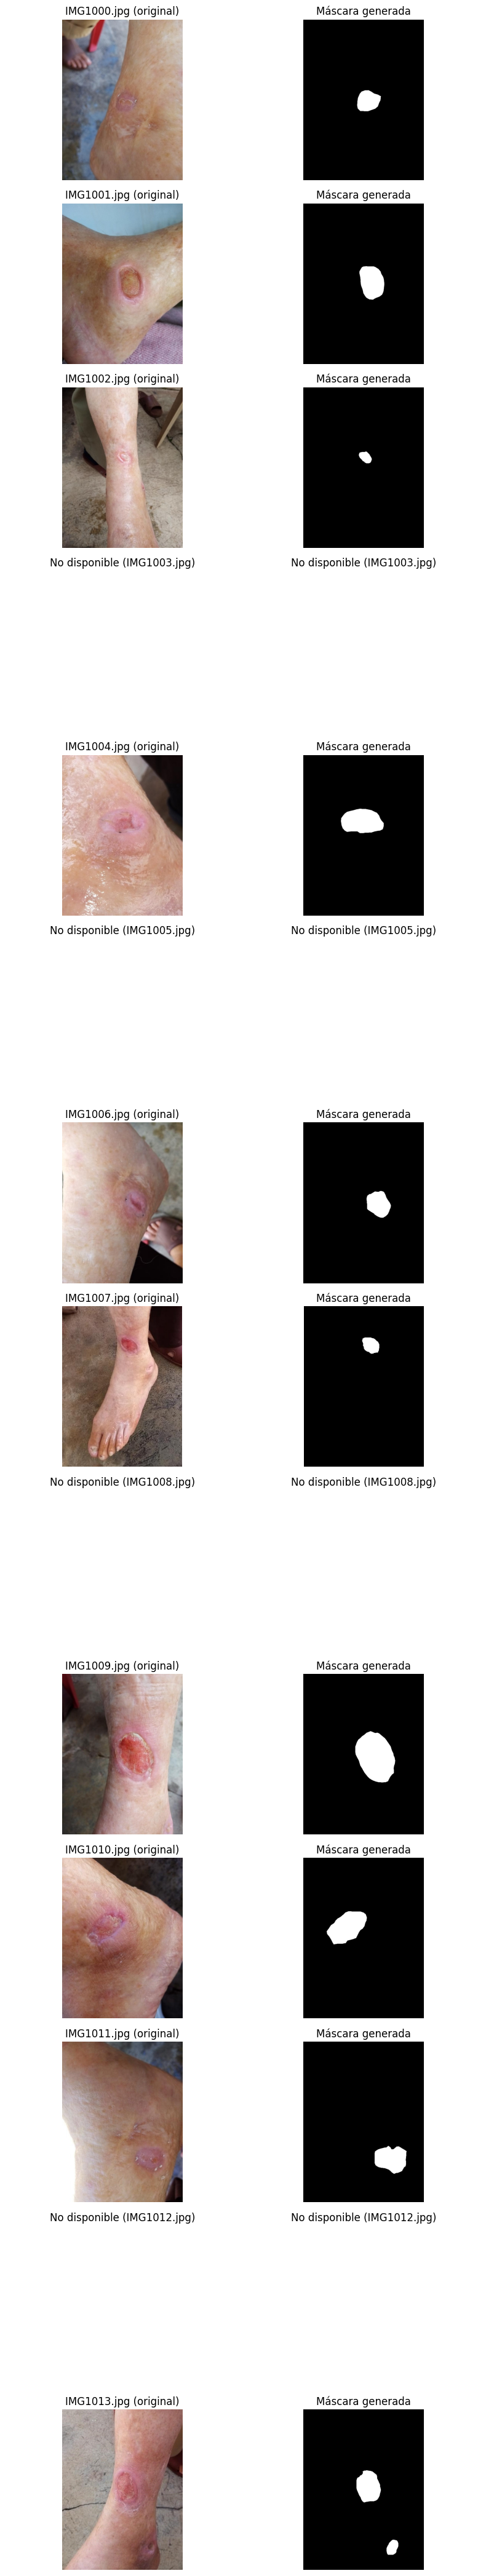

In [15]:
import matplotlib.pyplot as plt

image_ids = range(1000, 1014)  # mostrará IMG1000.jpg a IMG1012.jpg

cols = 2  # imagen y máscara
rows = len(image_ids)
fig, axes = plt.subplots(rows, cols, figsize=(8, 3 * rows))

for i, img_id in enumerate(image_ids):
    img_name = f"IMG{img_id}.jpg"
    mask_name = img_name.replace(".jpg", "_mask.png").replace(".jpeg", "_mask.png").replace(".png", "_mask.png")

    try:
        # Cargar imagen y máscara
        img = Image.open(os.path.join(img_dir, img_name)).convert("RGB")
        mask = Image.open(os.path.join(mask_output_dir, mask_name)).convert("L")

        # Mostrar imagen original
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"{img_name} (original)")
        axes[i, 0].axis("off")

        # Mostrar máscara
        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title("Máscara generada")
        axes[i, 1].axis("off")

    except Exception:
        # Si falta la imagen o la máscara
        for j in range(2):
            axes[i, j].axis("off")
            axes[i, j].set_title(f"No disponible ({img_name})")

plt.tight_layout()
plt.show()

Organizamos en la carpeta split de modo que cada particion train/test/val tenga su respectiva mascara en una subcarpeta

In [9]:
import os
import shutil

# Rutas base
base_path = "/content/dataset/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients"
masks_path = os.path.join(base_path, "masks")

# Particiones que tenemos
splits = ["train", "val", "test"]

for split in splits:
    split_path = os.path.join(base_path, "split", split)

    imgs_dir = os.path.join(split_path, "imgs")
    masks_dir = os.path.join(split_path, "masks")

    # Crear carpetas necesarias
    os.makedirs(imgs_dir, exist_ok=True)
    if split != "test":  # test no tendrá máscaras
        os.makedirs(masks_dir, exist_ok=True)

    # Mover imágenes originales a imgs/
    for file in os.listdir(split_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            shutil.move(os.path.join(split_path, file), os.path.join(imgs_dir, file))

    # Copiar máscaras solo para train y val
    if split != "test":
        copied = 0
        missing = 0
        for file in os.listdir(imgs_dir):
            mask_name = (
                file.replace(".jpg", "_mask.png")
                    .replace(".jpeg", "_mask.png")
                    .replace(".png", "_mask.png")
            )
            mask_source = os.path.join(masks_path, mask_name)
            mask_target = os.path.join(masks_dir, mask_name)

            if os.path.exists(mask_source):
                shutil.copy(mask_source, mask_target)
                copied += 1
            else:
                missing += 1

        print(f"📁 {split.upper()}: {copied} máscaras copiadas, {missing} no encontradas.")
    else:
        print(f"📁 {split.upper()}: solo contiene imágenes (sin máscaras).")

print("\n✅ Estructura de dataset reorganizada correctamente.")


📁 TRAIN: 485 máscaras copiadas, 0 no encontradas.
📁 VAL: 122 máscaras copiadas, 0 no encontradas.
📁 TEST: solo contiene imágenes (sin máscaras).

✅ Estructura de dataset reorganizada correctamente.


Una vez tengamos organizado correctamente nuestro dataset y nuestros archivos podemos empezar a crear nuestros objetos con las respectivas particiones de nuestro dataset

In [10]:
import tensorflow as tf

base_dir = "/content/dataset/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients/split"

train_img_dir = os.path.join(base_dir, "train", "imgs")
train_mask_dir = os.path.join(base_dir, "train", "masks")

val_img_dir = os.path.join(base_dir, "val", "imgs")
val_mask_dir = os.path.join(base_dir, "val", "masks")

test_img_dir = os.path.join(base_dir, "test", "imgs")



In [11]:
IMG_SIZE = (256, 256)

def load_image_and_mask(img_path, mask_path):
    # Cargar imagen
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0  # Normalizar

    # Cargar máscara
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE)
    mask = tf.cast(mask, tf.float32) / 255.0  # Escalar [0,1]

    return img, mask

def load_image_only(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

In [12]:
train_images = sorted([os.path.join(train_img_dir, x) for x in os.listdir(train_img_dir)])
train_masks = sorted([os.path.join(train_mask_dir, x) for x in os.listdir(train_mask_dir)])

val_images = sorted([os.path.join(val_img_dir, x) for x in os.listdir(val_img_dir)])
val_masks = sorted([os.path.join(val_mask_dir, x) for x in os.listdir(val_mask_dir)])

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_masks))

train_ds = train_ds.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
test_images = sorted([os.path.join(test_img_dir, x) for x in os.listdir(test_img_dir)])
test_ds = tf.data.Dataset.from_tensor_slices(test_images)
test_ds = test_ds.map(load_image_only, num_parallel_calls=tf.data.AUTOTUNE)

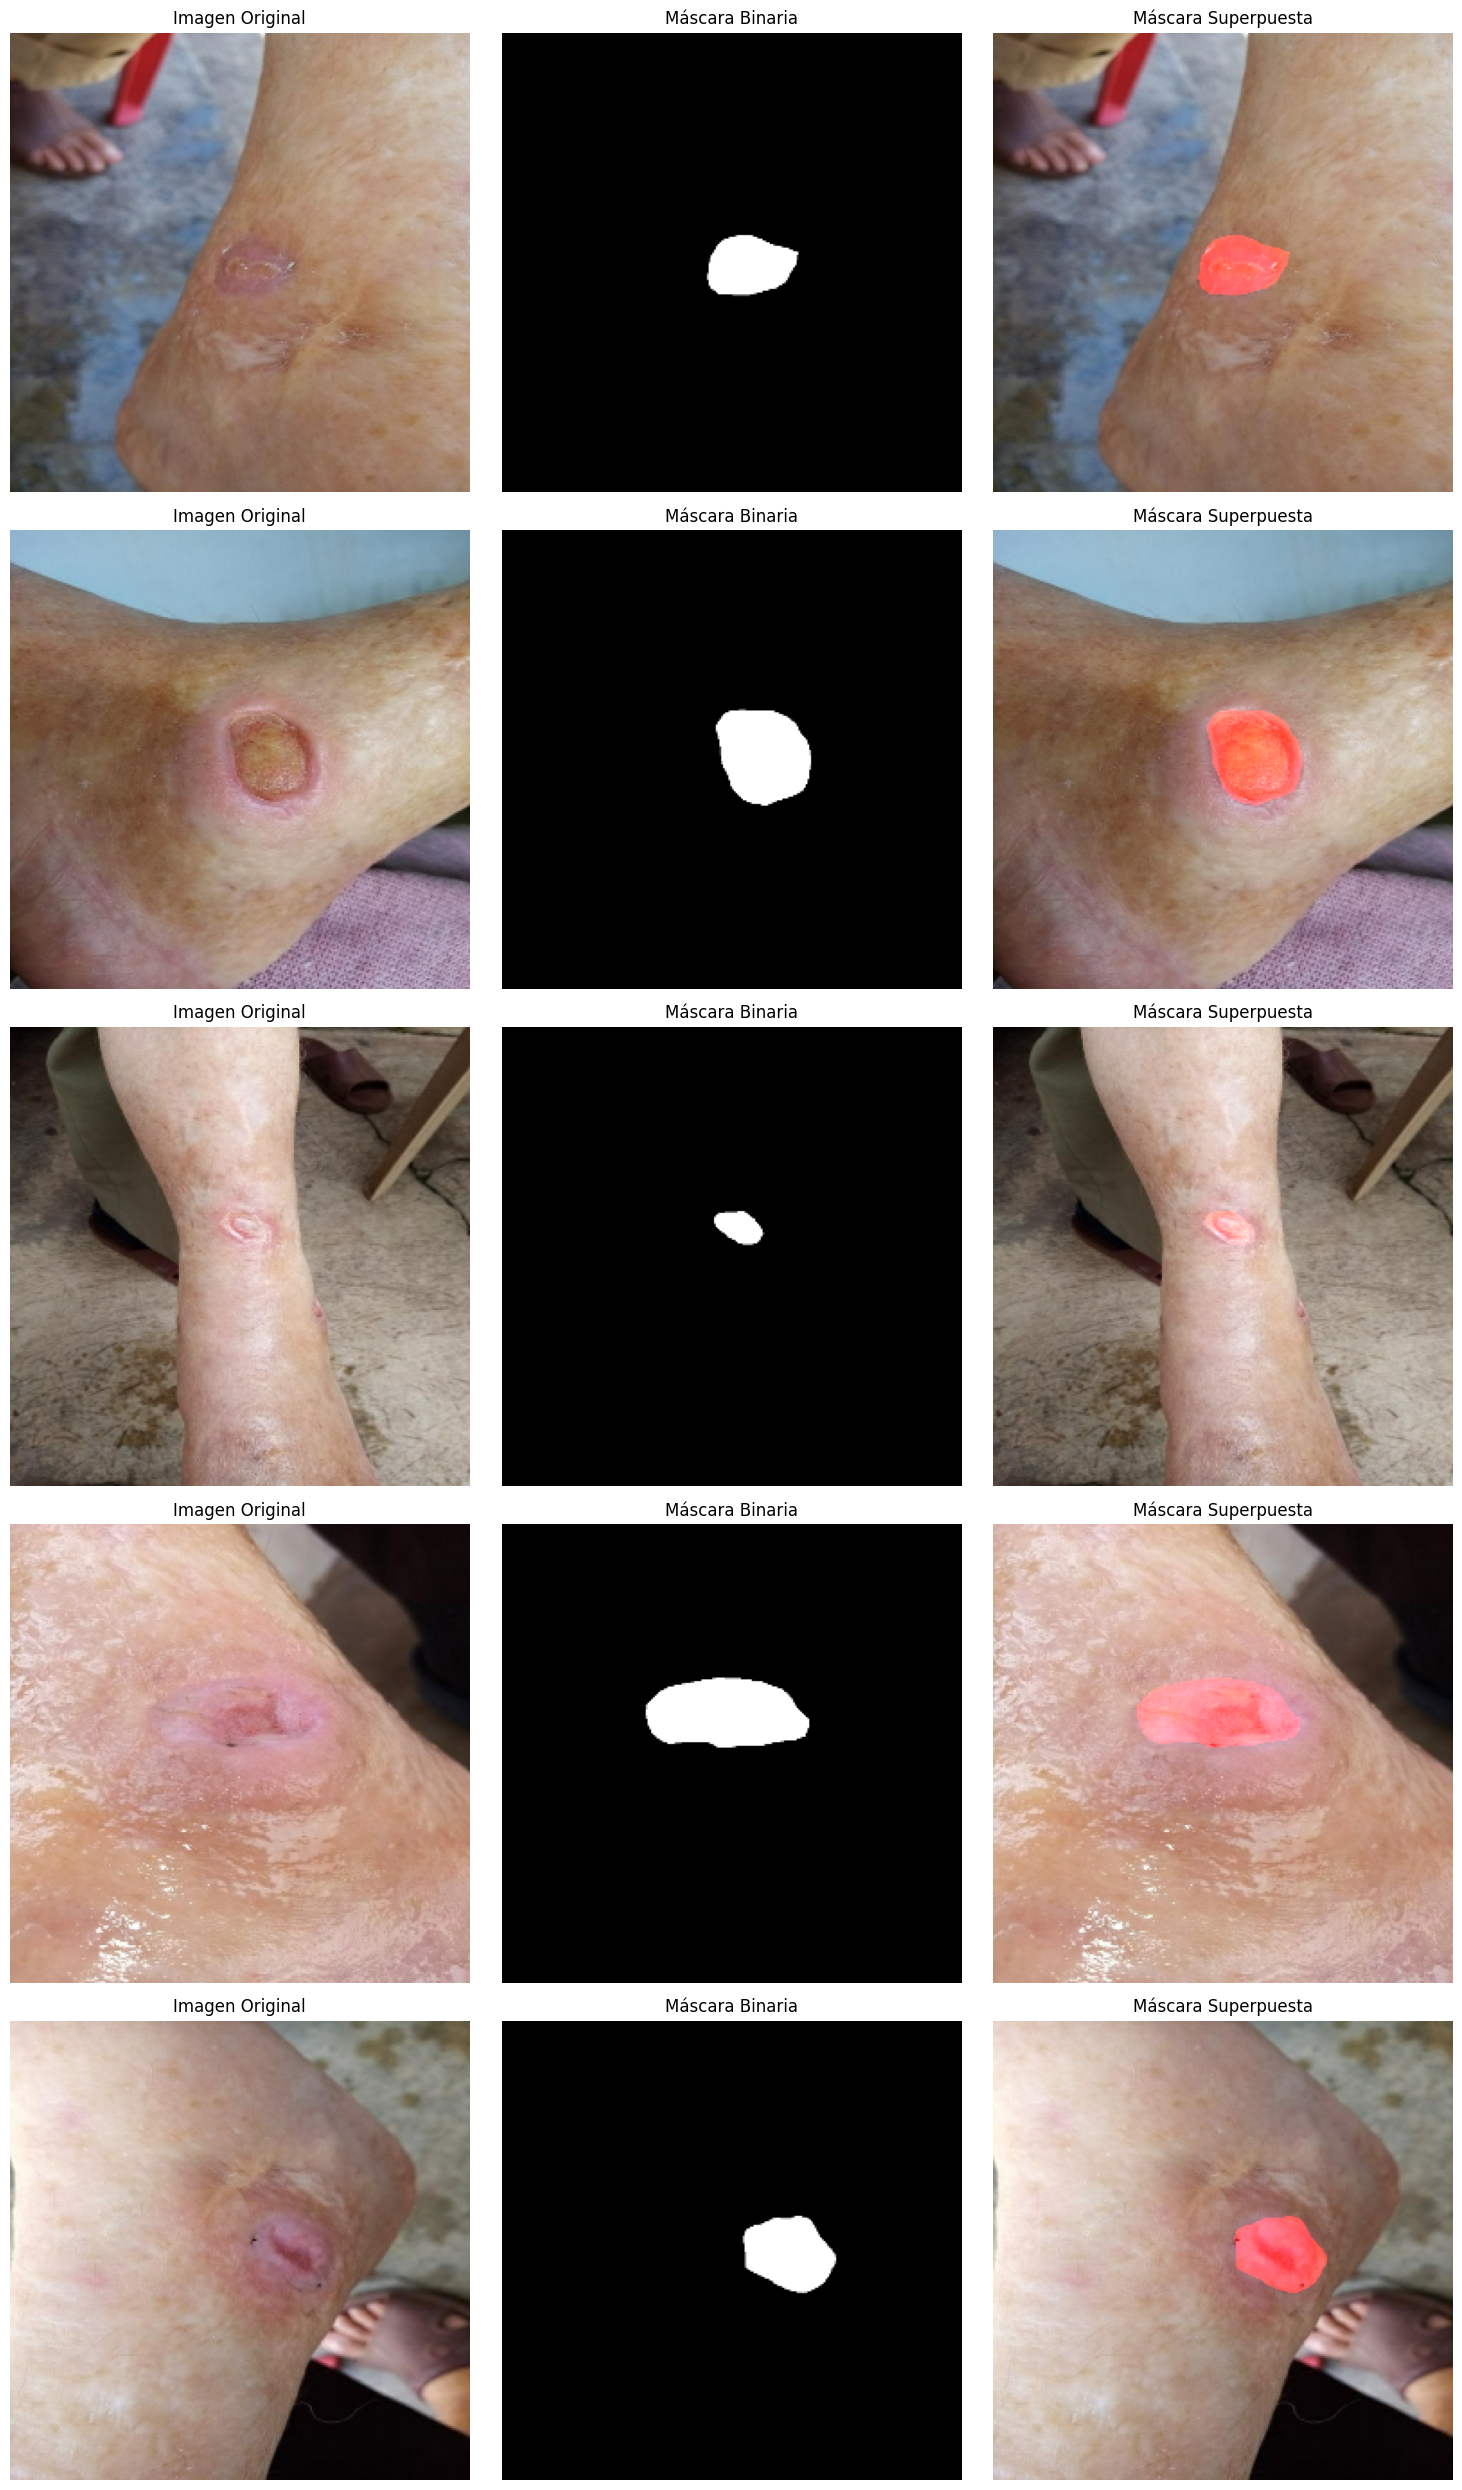

In [19]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

#Visualizar las imagenes con sus mascaras superpuestas
def display_image_and_mask(dataset, num_images=5):

    plt.figure(figsize=(15, num_images * 5))

    for i, (image, mask) in dataset.take(num_images).enumerate():
        image_np = image.numpy()
        mask_np = mask.numpy().squeeze() # Eliminar la dimensión del canal de la máscara

        # Crear imagen con máscara superpuesta
        image_overlay = np.copy(image_np)

        # Crear una capa rojiza semitransparente para la máscara
        red_mask = np.zeros_like(image_overlay)
        red_mask[:, :, 0] = 1.0
        red_mask = red_mask * mask_np[:, :, np.newaxis] * 0.5
        # Superponer la máscara roja
        image_with_overlay = image_overlay + red_mask
        image_with_overlay = np.clip(image_with_overlay, 0, 1)

        # Visualizar la imagen original
        ax = plt.subplot(num_images, 3, i.numpy() * 3 + 1)
        plt.imshow(image_np)
        plt.title("Imagen Original")
        plt.axis("off")

        # Visualizar la máscara binaria
        ax = plt.subplot(num_images, 3, i.numpy() * 3 + 2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("Máscara Binaria")
        plt.axis("off")

        # Visualizar la imagen con máscara superpuesta
        ax = plt.subplot(num_images, 3, i.numpy() * 3 + 3)
        plt.imshow(image_with_overlay)
        plt.title("Máscara Superpuesta")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Ejemplo de uso con train_ds
display_image_and_mask(train_ds)


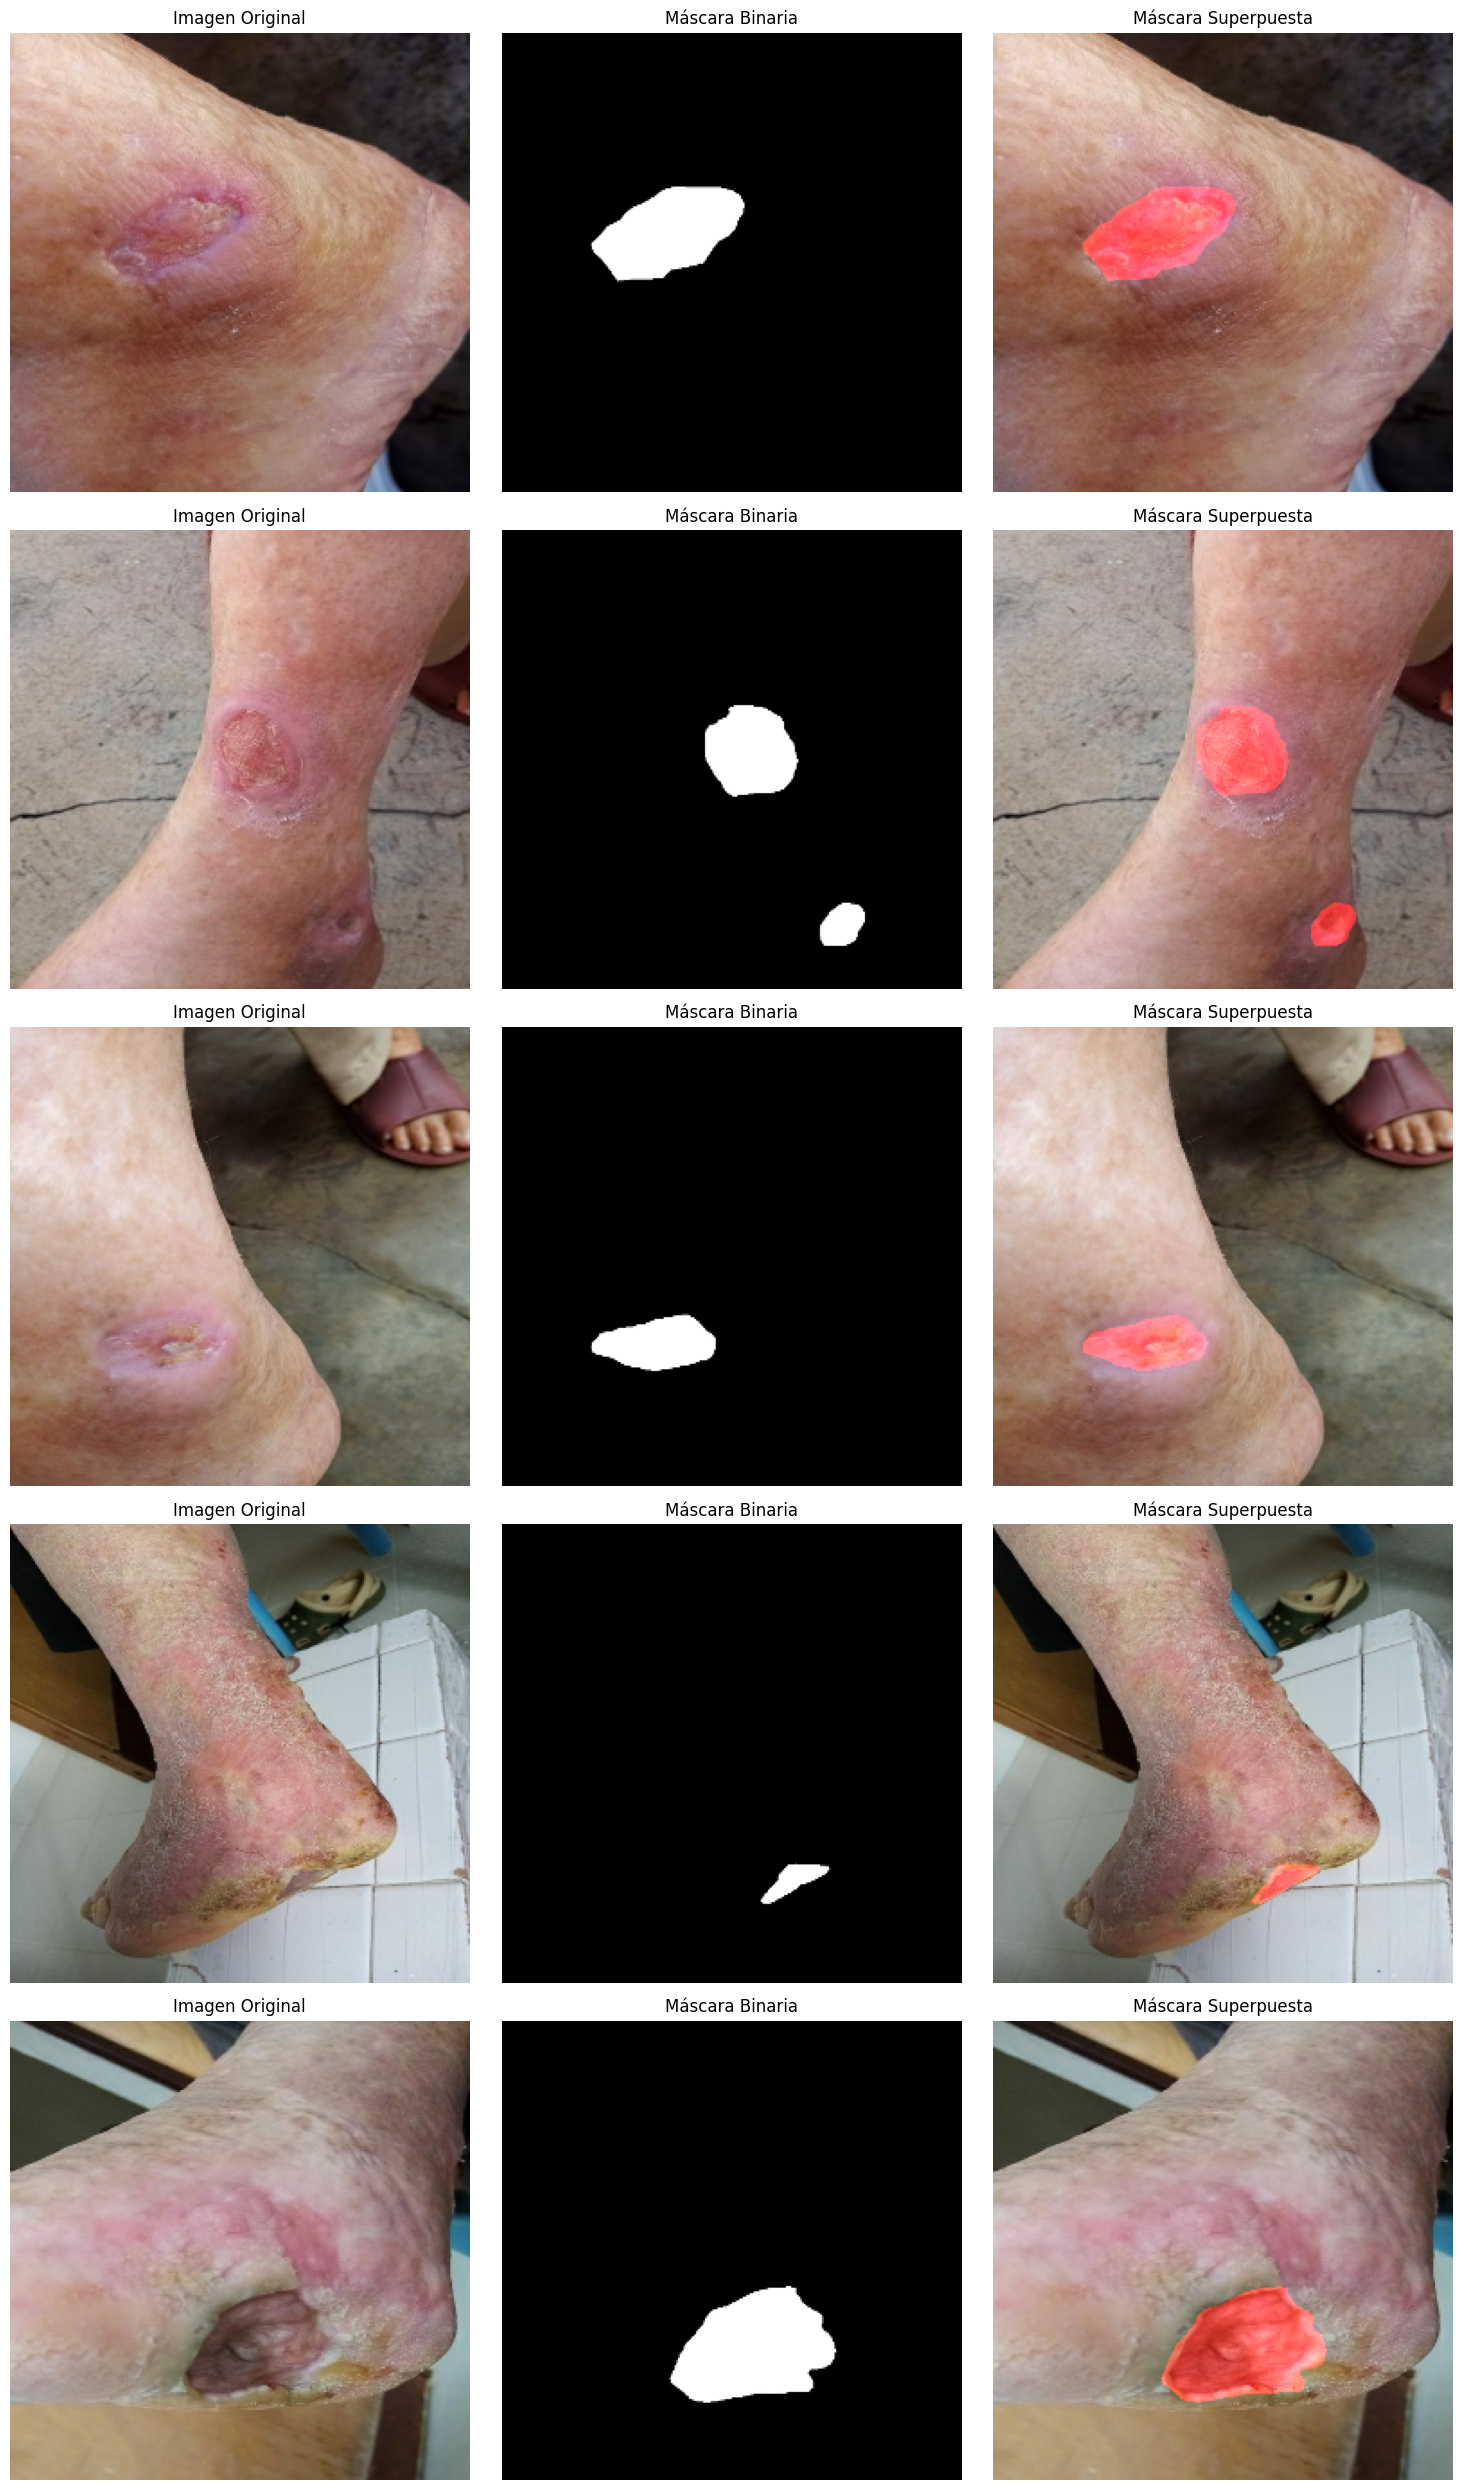

In [20]:
#Uso en el validation dataset
display_image_and_mask(val_ds)

Una vez tenemos los datasets preparados para la etapa de entrenamiento comenzaremos a ver que modelos podemos usar para un buen performance en segmentacion